In [40]:
# ************************************************************************* #
#     Author:   Pawel Rosikiewicz                                           #       
#     Copyrith: IT IS NOT ALLOWED TO COPY OR TO DISTRIBUTE                  #
#               these file without written                                  #
#               persmission of the Author                                   #
#     Contact:  prosikiewicz@gmail.com                                      #
#                                                                           #
# ************************************************************************* #

# Config

# basedir
basedir = '/Users/pawel/Desktop/Activities/005__COURSES/000__EPFLext_ADSML/Module 4 __ Project/solution'

# project config
project_name = "Pawel_Rosikiewicz_EPFLext_Project4"
dataset_name = "swissroads" # its the same datasets as with swissroad, but train and valid datsets are stored together, 
subset_names = ["train", "valid", "test"]
class_colors = {          "car": "orange",
                          "van": "steelblue",
                          "truck": "red",
                          "bike": "forestgreen",
                          "motorcycle" : "purple",
                           "other": "dimgrey"}

# task config
task_name = "cnn" # tranfer learning ussing 1 or 2 layed NN, and features extracted wiht tf hub
module_names = ["generator_raw_images"]
# ....
train_subset_name = "train_valid_together" # CAUTION ! - ONLY ONE FILE NAME ALLOWED, 
test_subset_names = ["test"] # can be more then one, 
img_imput_size = [(299, 299)] # required by imagenet, 
generator_batch_size = 10000 # nr of images that will be loaded in order of appearance to one batch with enc oded feastures, if less found, all will be used,

# Note:
"""in some cases train, test and valid datasets, may be also subset names of the datasets, 
   this script works by loading selected daset subsets into either train and test category, 
   validation ataset is created automatically, at random fro 30% of train dataset.
   all saved predictions have reference to original images in raw data
""";

In [32]:
import os # allow changing, and navigating files and folders, 
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import random # functions that use and generate random numbers

import pickle
import warnings
import numpy as np # support for multi-dimensional arrays and matrices
import pandas as pd # library for data manipulation and analysis
import seaborn as sns # advance plots, for statistics, 
import matplotlib as mpl # to get some basif functions, heping with plot mnaking 
import matplotlib.pyplot as plt # for making plots, 

import tensorflow as tf
from PIL import Image, ImageDraw
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
import graphviz # allows visualizing decision trees,

In [33]:
os.chdir(basedir)
sys.path.append(basedir)

# my tools, loaded only form basedir, 
from src.utils.data_loaders import load_encoded_imgbatch_using_logfile, load_raw_img_batch, load_raw_img_batch_with_custom_datagen
from src.utils.example_plots_after_clustering import plot_img_examples, create_spaces_between_img_clusters, plot_img_examples_from_dendrogram
from src.utils.annotated_pie_charts import annotated_pie_chart_with_class_and_group, prepare_img_classname_and_groupname
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.feature_extraction_tools import encode_images, create_augmented_images
from src.utils.logreg_tools import my_logredCV, plot_examples_with_predictions_and_proba, plot_examples_with_predictions_and_proba_gamma
from src.utils.random_forest import random_forest_grid_search, plot_random_tree_summary_andor_table
from src.utils.model_summary_plots import plot_grid_acc_and_return_summary_df, visual_model_summary
from src.utils.SVM_tools import SVM_grid_search, plot_grid_acc_and_return_summary_df
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.model_summary_plots import plot_grid_acc_and_return_summary_df, visual_model_summary, model_gridsearch_summary_plots
from src.utils.knn_tools import knn_grid_search
from src.utils.dense_networks_tools import create_keras_one_layer_dense_model, create_keras_two_layer_dense_model, denseNN_grid_search, plot_NN_loss_acc
from src.utils.example_plots import plot_example_images_with_datagenerator
from src.utils.cnn_tools import plot_NN_loss_acc, create_convNN, cnn_gridSearch

# one of my functions was generating warnign, on copies, despite using proper syntax, 
warnings.filterwarnings("ignore")

# To avoid restaring the kernel with keras, preffered solution; use conda install nomkl
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [34]:
import PIL.Image as Image
import tensorflow.keras as keras
from tensorflow.keras import backend as K # used for housekeeping of tf models, 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import Sequential, activations, initializers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [41]:
PATH_raw = os.path.join(basedir, "data/raw", dataset_name)
PATH_encoded = os.path.join(basedir, "data/interim", dataset_name)
PATH_results = os.path.join(basedir, "data/results", f"{dataset_name}_{task_name}")

# create new direcory for task results, 
try: 
    os.mkdir(PATH_results)
    try:
        os.chdir(PATH_results)
        print("PATH_results was created")
    except:
        print("ERROR: PATH_results was not created correctly")
except: 
    print("file already exist, or PATH_results was not created correctly")
    
print(PATH_results)

file already exist, or PATH_results was not created correctly
/Users/pawel/Desktop/Activities/005__COURSES/000__EPFLext_ADSML/Module 4 __ Project/solution/data/results/swissroads_cnn


# Test different method for image augmentation

Found 419 images belonging to 6 classes.


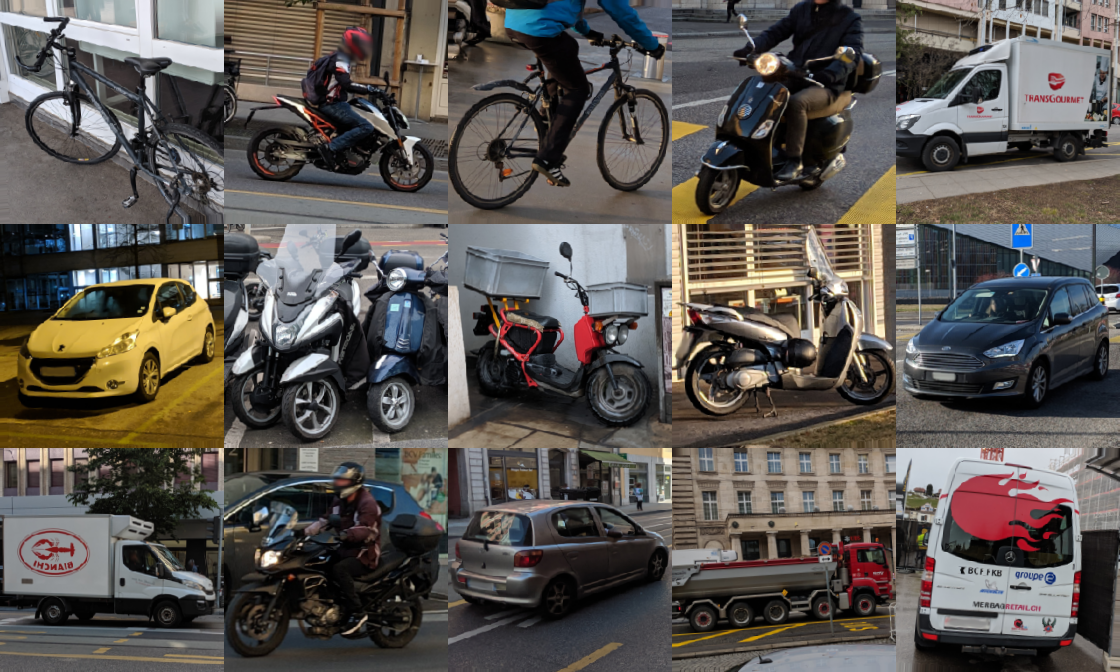

In [36]:
# set image size for plotting examples, 
img_size=(224, 224)

ImageDataGenerator_kwargs_v2  = dict(
            horizontal_flip=True, 
            rotation_range=5
)

# Params, 
img_size=(224, 224)

# .. create data generator,
datagen = ImageDataGenerator(rescale=1/255, **ImageDataGenerator_kwargs_v2)  

# .. create iterator,
datagen_iter = datagen.flow_from_directory(
                        os.path.join(PATH_raw, train_subset_name), 
                        batch_size=5, 
                        target_size=img_size,
                        shuffle=True
                    )

plot_example_images_with_datagenerator(
            generator=datagen_iter,
            n_batches=3,
            image_dim=img_size

        )


# grid search over cnn networks with different parameters, 

generator_raw_images _________________________________________ 2020-11-22 01:22:14.751475
.Found 297 images belonging to 6 classes.
Found 122 images belonging to 6 classes.
Found 50 images belonging to 6 classes.
Found 50 images belonging to 6 classes.
Epoch 1/100
10/10 [==============================] - 3s 257ms/step - loss: 2.3178 - acc: 0.2189 - val_loss: 2.1334 - val_acc: 0.2787
Epoch 2/100
10/10 [==============================] - 2s 205ms/step - loss: 2.1043 - acc: 0.2323 - val_loss: 2.0289 - val_acc: 0.2459
Epoch 3/100
10/10 [==============================] - 2s 194ms/step - loss: 1.9705 - acc: 0.2694 - val_loss: 1.9218 - val_acc: 0.2377
Epoch 4/100
10/10 [==============================] - 2s 203ms/step - loss: 1.8352 - acc: 0.3468 - val_loss: 1.7651 - val_acc: 0.4098
Epoch 5/100
10/10 [==============================] - 2s 192ms/step - loss: 1.6001 - acc: 0.4411 - val_loss: 1.6497 - val_acc: 0.4344
Epoch 6/100
10/10 [==============================] - 2s 189ms/step - loss: 1.4765 

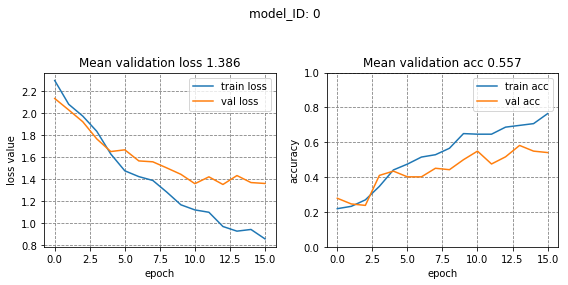

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 300)               3840300   
_________________________________________________________________
dropout (Dropout)            (None, 300)               0

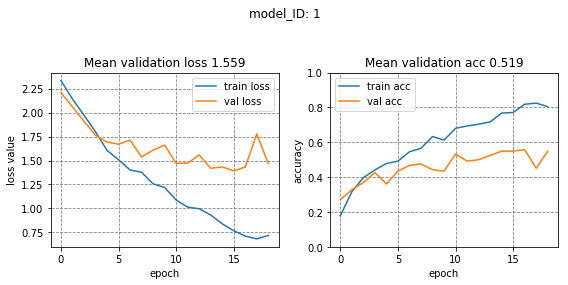

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 300)               3840300   
_________________________________________________________________
dropout (Dropout)            (None, 300)               0

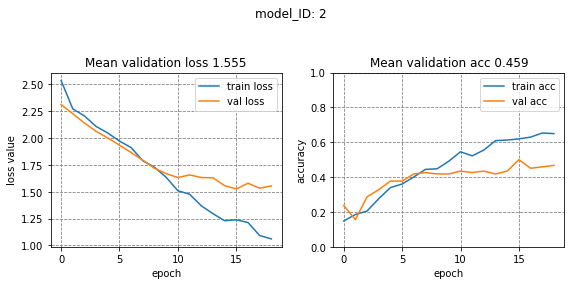

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 300)               3840300   
_________________________________________________________________
dropout (Dropout)            (None, 300)               0

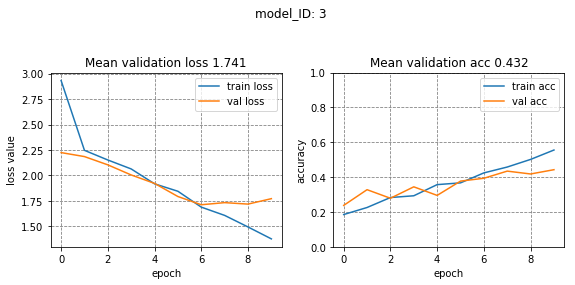

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0         
_________________________________________________________________
dense (Dense)                (None, 300)               25958700  
_________________________________________________________________
dropout (Dropout)            (None, 300)               0

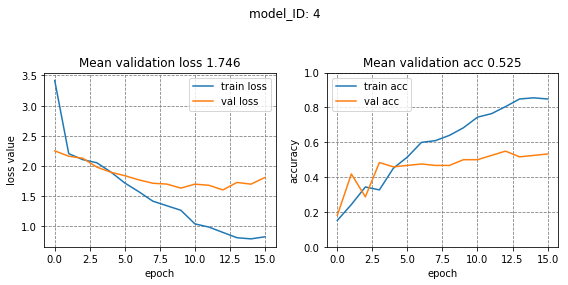

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0         
_________________________________________________________________
dense (Dense)                (None, 300)               25958700  
_________________________________________________________________
dropout (Dropout)            (None, 300)               0

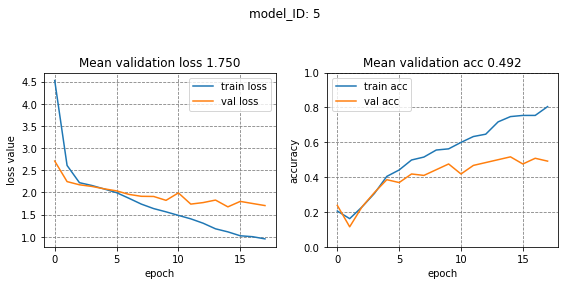

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0         
_________________________________________________________________
dense (Dense)                (None, 300)               25958700  
_________________________________________________________________
dropout (Dropout)            (None, 300)               0

In [43]:
grid = ParameterGrid({
    # -- generators, ........................
    "model":["two_dense_layers"],
    "random_state":[0], # used to divide train,valid datasets,
    "generator__target_size" :[(96, 96), (224, 224)],#,(224, 224)], # tuple, for each image x,y dimension in pixels, 
    #    "generator__target_size" :[(112, 112),(224, 224)], # tuple, for each image x,y dimension in pixels, 

    # ..
    "train_generator__batch_size": [32, 64, 128],
    "train_generator__validation_split" : [0.3], # caution its opposite then in train_test_split__train_size"
    "train_generator__kwargs" : [ImageDataGenerator_kwargs_v2], # for data augmentation, must be provided as dict, 
    # ..
    "test_generator__batch_size": [None],  # max available images will be used, !
     
    # -- conv model, ........................
    'Conv2D_1__filters': [64], 
    'Conv2D_1__kernel_size': [5], 
    'Conv2D_1__stride': [2], 
    'Conv2D_1__activation' : ['relu'], 
    'MaxPool2D_1__pool_size': [2], 
    'Conv2D_2__filters': [128], 
    'Conv2D_2__kernel_size': [3], 
    'Conv2D_2__stride': [1], 
    'Conv2D_2__activation' : ["relu"], 
    'MaxPool2D_2__pool_size': [2], 
    
    # -- dense nn, ...........................
    "h1_unit_size":[300],
    "h1_Dropout" : [0.5],
    "h1_activation": ["relu"],
    "h1_l2": [0.001],
    # ..
    "out_activation":["softmax"],
    "out_l2": [0.001],
    # ..
    "optimizer":["Adam"],
    "metrics": [["acc"]],
    
    # -- training, ...........................
    "EarlyStopping__patience": [3],
    "fit_generator__epoch": [100]     
    
})

# .. 
save_results=True
for module_name in module_names:
    
    # run grid search, 
    dt_results_list, model_predictions_dict, model_history_dict = cnn_gridSearch(                  
        grid=grid, 
        method_name=task_name,
        module_name=module_names[0],
        PATH_raw=PATH_raw,
        train_subset_name=train_subset_name,
        test_subset_names=test_subset_names,
        # ...                    
        store_predictions=True,
        track_progres=True,
        model_fit_verbose=1,
        verbose=False,
        plot_history=True 
    )   
    
    if save_results == True:
    
        # STEP 2. save files 
        os.chdir(PATH_results)

        # .. save summary table
        pd.DataFrame(dt_results_list).to_csv(f"{task_name}__{module_name}__{dataset_name}__summary_table.csv", header=True)

        # .. save the model_predictions_dict into a pickle file
        with open(f"{task_name}__{module_name}__{dataset_name}__model_predictions_dict.p", 'wb') as file: # wb - write binary,
            pickle.dump(model_predictions_dict, file)     

        # .. save the model_history_dict into a pickle file
        with open(f"{task_name}__{module_name}__{dataset_name}__model_history_dict.p", 'wb') as file: # wb - write binary,
            pickle.dump(model_history_dict, file)         
    else:
        pass
        
print("DONE ...")
print(pd.DataFrame(dt_results_list).model_acc_test)

In [26]:
pd.DataFrame(dt_results_list).model_acc_test

0    0.52
Name: model_acc_test, dtype: float64